In [1]:
import pandas as pd
import numpy as np
from eodhd import APIClient
import sys
sys.path.insert(0, "/home/sam/projects/Factor-Research/src")
from Features import fundamental_features_new, fundamental_features, technical_features
import talib
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import sklearn
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import optuna
from optuna import Trial
import shap

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

/home/sam/projects/Factor-Research/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
zacks_fc = pd.read_csv("../data/fundamental_data/ZACKS_FC.csv", delimiter=",")
zacks_fc["per_end_date"] = pd.to_datetime(zacks_fc["per_end_date"])
zacks_fc["per_end_date"] = zacks_fc["per_end_date"].dt.tz_localize("US/Eastern")
zacks_fc["filing_date"] = pd.to_datetime(zacks_fc["filing_date"])
zacks_fc["filing_date"] = zacks_fc["filing_date"].dt.tz_localize("US/Eastern")
zacks_fc = zacks_fc.sort_values("per_end_date").set_index("per_end_date")

zacks_fr = pd.read_csv("../data/fundamental_data/ZACKS_FR.csv", delimiter=",")
zacks_fr["per_end_date"] = pd.to_datetime(zacks_fr["per_end_date"])
zacks_fr["per_end_date"] = zacks_fr["per_end_date"].dt.tz_localize("US/Eastern")
zacks_fr = zacks_fr.sort_values("per_end_date").set_index("per_end_date")

data = {"zacks_fc": zacks_fc, "zacks_fr": zacks_fr}

In [3]:
tickers_df = pd.read_excel(
    r"/home/sam/projects/Factor-Research/data/sp1500_cleaned.xlsx"
)
tickers = tickers_df["ticker"].tolist()
len(tickers)

1506

In [4]:
combined_features = []
for ticker in tickers:
    data = {"zacks_fc": zacks_fc, "zacks_fr": zacks_fr}
    try:
        print(f"Processing ticker: {ticker}")
        obj = fundamental_features_new.BuildFeatures(data, ticker)
        obj.process_financial_statements()
        obj.extend_monthly()

        tech = technical_features.BuildFeatures(ticker)
        tech.build_technical_features()
        tech.technical_features.index = tech.technical_features.index.tz_convert(
            "US/Eastern"
        )

        df = pd.merge_asof(
            obj.fundamental_features,
            tech.technical_features,
            left_index=True,
            right_index=True,
            direction="nearest",
        )

        obj.stock.sort_index(inplace=True)

        df = pd.merge_asof(
            df,
            obj.stock[["Close"]],
            left_index=True,
            right_index=True,
            direction="backward",
        )

        df.rename(columns={"Close": "Close_Price"}, inplace=True)

        df["ticker"] = ticker

        combined_features.append(df)
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

Processing ticker: VRSK
Error processing VRSK: Merge keys contain null values on left side
Processing ticker: EVTC
Error processing EVTC: Merge keys contain null values on left side
Processing ticker: AA
Error processing AA: Merge keys contain null values on left side
Processing ticker: PFG
Processing ticker: NXPI
Error processing NXPI: Merge keys contain null values on left side
Processing ticker: CELH
Error processing CELH: Merge keys contain null values on left side
Processing ticker: AXP
Processing ticker: VZ
Processing ticker: BA
Error processing BA: Merge keys contain null values on left side
Processing ticker: RCL
Error processing RCL: Merge keys contain null values on left side
Processing ticker: DOW
Error processing DOW: Merge keys contain null values on left side
Processing ticker: CAT
Processing ticker: SCVL
Processing ticker: JPM
Error processing JPM: Merge keys contain null values on left side
Processing ticker: CVX
Processing ticker: LII
Error processing LII: Merge keys c

Failed to get ticker 'BRK/B' reason: Expecting value: line 1 column 1 (char 0)
$BRK/B: possibly delisted; no timezone found


Error processing BRK/B: 'Index' object has no attribute 'tz_convert'
Processing ticker: BBY
Error processing BBY: Merge keys contain null values on left side
Processing ticker: HUBB
Processing ticker: HRB
Error processing HRB: Merge keys contain null values on left side
Processing ticker: BOOT
Error processing BOOT: Merge keys contain null values on left side
Processing ticker: IDA
Processing ticker: IT
Processing ticker: BSX
Processing ticker: IEX
Processing ticker: BMY
Processing ticker: WKC
Processing ticker: BF/B


Failed to get ticker 'BF/B' reason: Expecting value: line 1 column 1 (char 0)
$BF/B: possibly delisted; no timezone found


Error processing BF/B: 'Index' object has no attribute 'tz_convert'
Processing ticker: CTRA
Processing ticker: CCS
Error processing CCS: Merge keys contain null values on left side
Processing ticker: CCL
Processing ticker: CARG
Error processing CARG: Merge keys contain null values on left side
Processing ticker: KMT
Processing ticker: LUMN
Processing ticker: LZB
Processing ticker: SR
Processing ticker: PRI
Error processing PRI: Merge keys contain null values on left side
Processing ticker: CR
Error processing CR: Merge keys contain null values on left side
Processing ticker: CLF
Processing ticker: ALE
Processing ticker: CLX
Processing ticker: MLI
Processing ticker: CMS
Processing ticker: BANF
Processing ticker: NFG
Processing ticker: NPK
Processing ticker: CL
Processing ticker: NJR
Processing ticker: EXPD
Processing ticker: CMA
Processing ticker: NMIH
Error processing NMIH: Merge keys contain null values on left side
Processing ticker: AL
Error processing AL: Merge keys contain null va

Failed to get ticker 'MOG/A' reason: Expecting value: line 1 column 1 (char 0)
$MOG/A: possibly delisted; no timezone found


Error processing MOG/A: 'Index' object has no attribute 'tz_convert'
Processing ticker: ADBE
Processing ticker: AES
Processing ticker: DPZ
Processing ticker: AMGN
Processing ticker: MCY
Processing ticker: AAPL
Processing ticker: ADSK
Processing ticker: CTAS
Processing ticker: CSR
Error processing CSR: Merge keys contain null values on left side
Processing ticker: CMCSA
Processing ticker: TAP
Processing ticker: PKG
Error processing PKG: Merge keys contain null values on left side
Processing ticker: SLP
Error processing SLP: Merge keys contain null values on left side
Processing ticker: KLAC
Processing ticker: BXMT
Processing ticker: NBTB
Processing ticker: MKC
Processing ticker: NDSN
Processing ticker: NEOG
Processing ticker: JWN
Processing ticker: XPO
Processing ticker: NNN
Processing ticker: PCAR
Error processing PCAR: Merge keys contain null values on left side
Processing ticker: CADE
Error processing CADE: Merge keys contain null values on left side
Processing ticker: NVR
Processing

$MDU: possibly delisted; no price data found  (1d 1926-03-30 -> 2025-03-05)


Error processing MDU: 'Index' object has no attribute 'tz_convert'
Processing ticker: AXTA
Error processing AXTA: Merge keys contain null values on left side
Processing ticker: MGM
Processing ticker: BJRI
Processing ticker: HXL
Processing ticker: OUT
Error processing OUT: Merge keys contain null values on left side
Processing ticker: ALLE
Error processing ALLE: Merge keys contain null values on left side
Processing ticker: CUBE
Processing ticker: DNOW
Error processing DNOW: Merge keys contain null values on left side
Processing ticker: NSP
Processing ticker: KRC
Processing ticker: CNR
Error processing CNR: Merge keys contain null values on left side
Processing ticker: TOL
Processing ticker: SNCY
Error processing SNCY: Merge keys contain null values on left side
Processing ticker: ADMA
Error processing ADMA: Merge keys contain null values on left side
Processing ticker: BL
Error processing BL: Merge keys contain null values on left side
Processing ticker: PARA
Processing ticker: APPF
Er

$PATK: possibly delisted; no price data found  (1d 1926-03-30 -> 2025-03-05)


Error processing PATK: 'Index' object has no attribute 'tz_convert'
Processing ticker: VCEL
Error processing VCEL: Merge keys contain null values on left side
Processing ticker: PPBI
Error processing PPBI: Merge keys contain null values on left side
Processing ticker: SBSI
Error processing SBSI: Merge keys contain null values on left side
Processing ticker: VRTS
Error processing VRTS: Merge keys contain null values on left side
Processing ticker: HLI
Error processing HLI: Merge keys contain null values on left side
Processing ticker: NARI
Error processing NARI: Merge keys contain null values on left side
Processing ticker: YELP
Error processing YELP: Merge keys contain null values on left side
Processing ticker: FTDR
Error processing FTDR: Merge keys contain null values on left side
Processing ticker: ADEA
Processing ticker: QLYS
Error processing QLYS: Merge keys contain null values on left side
Processing ticker: NOG
Processing ticker: GES
Error processing GES: Merge keys contain null

Failed to get ticker 'CWEN/A' reason: Expecting value: line 1 column 1 (char 0)
$CWEN/A: possibly delisted; no timezone found


Error processing CWEN/A: 'Index' object has no attribute 'tz_convert'
Processing ticker: CHDN
Processing ticker: PAYO
Error processing PAYO: Merge keys contain null values on left side
Processing ticker: ENOV
Error processing ENOV: Merge keys contain null values on left side
Processing ticker: BANC
Processing ticker: ITT
Processing ticker: XNCR
Error processing XNCR: Merge keys contain null values on left side
Processing ticker: FOXA
Error processing FOXA: Merge keys contain null values on left side
Processing ticker: KRG
Processing ticker: FOX
Error processing FOX: Merge keys contain null values on left side
Processing ticker: STE
Processing ticker: UCB
Processing ticker: VAL
Error processing VAL: Merge keys contain null values on left side
Processing ticker: OFG
Processing ticker: AMKR
Processing ticker: RYAN
Error processing RYAN: Merge keys contain null values on left side
Processing ticker: OTTR
Processing ticker: NYT
Processing ticker: SSTK
Error processing SSTK: Merge keys conta

In [5]:
tech.technical_features

,SMA_50,SMA_200,Chaikin_ADI_Line,Chaikin_ADI_Oscillator,ADM_Index,ADM_Index_Rating,Absolute_Price_Oscillator,Average_True_Range,Average_Price,Bollinger_Band_Upper,...,Plus_Directional_Movement,Percentage_Price_Oscillator,Median_Price,Money_Flow_Index,MidPoint_over_period,Midpoint_Price_over_period,Lowest_value_over_period,Index_of_lowest_value_over_period,Highest_value_over_period,Index_of_highest_value_over_period
Date,,,,,,,,,,,,,,,,,,,,,
2013-02-08 00:00:00-05:00,NaN,NaN,-3221442.62653675,NaN,NaN,NaN,NaN,NaN,5.13046021,NaN,...,NaN,NaN,5.12792220,NaN,NaN,NaN,NaN,0,NaN,0
2013-02-11 00:00:00-05:00,NaN,NaN,-3273501.83216419,NaN,NaN,NaN,NaN,NaN,5.02450212,NaN,...,NaN,NaN,5.01244684,NaN,NaN,NaN,NaN,0,NaN,0
2013-02-12 00:00:00-05:00,NaN,NaN,-3273503.46962456,NaN,NaN,NaN,NaN,NaN,4.97437625,NaN,...,NaN,NaN,4.98706603,NaN,NaN,NaN,NaN,0,NaN,0
2013-02-13 00:00:00-05:00,NaN,NaN,-3128302.76701105,NaN,NaN,NaN,NaN,NaN,5.04100031,NaN,...,NaN,NaN,5.04417270,NaN,NaN,NaN,NaN,0,NaN,0
2013-02-14 00:00:00-05:00,NaN,NaN,-3018302.24248968,NaN,NaN,NaN,NaN,NaN,5.05368780,5.11579549,...,NaN,NaN,5.04543953,NaN,NaN,NaN,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-27 00:00:00-05:00,6.81483400,7.32273465,-39399829.51121424,263284.31152535,12.12905262,13.57540806,0.01519229,0.18083460,6.85000002,6.92851335,...,0.53792750,0.04410401,6.85500002,50.10065792,6.72499990,6.78500009,6.55999994,3021,6.88999987,3030
2025-02-28 00:00:00-05:00,6.80985613,7.31974109,-37846607.99306557,553115.04639130,11.38366797,13.55528358,0.03211535,0.18148927,6.86500001,6.98849279,...,0.51950408,0.41305242,6.86500001,57.89810537,6.74499989,6.78500009,6.55999994,3021,6.92999983,3032
2025-03-03 00:00:00-05:00,6.76652192,7.30650306,-46332116.63848983,-2078535.58983411,15.36838181,15.87502493,-0.02474361,0.32209715,5.26750004,7.94086306,...,0.48239665,-0.03592358,5.24000001,35.36159518,6.00000000,5.90500021,5.07000017,3033,6.92999983,3032


In [6]:
combined_features[0]

,total revenue,ebitda,eps,Dividend Payout Ratio,total_current_assets,,m_ticker,ticker,comp_name,comp_name_2,...,Percentage_Price_Oscillator,Median_Price,Money_Flow_Index,MidPoint_over_period,Midpoint_Price_over_period,Lowest_value_over_period,Index_of_lowest_value_over_period,Highest_value_over_period,Index_of_highest_value_over_period,Close_Price
filing_date,,,,,,,,,,,,,,,,,,,,,
2006-04-30 20:00:00-04:00,2402.20000000,467.39980000,1.01000000,NaN,2281.80000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,1.00712991,29.05618694,56.19603051,28.60496044,28.64779955,27.79958916,1127,29.41033173,1135,29.30751991
2006-05-31 20:00:00-04:00,2402.20000000,467.39980000,1.01000000,NaN,2281.80000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,0.66643668,30.91825887,70.48490133,30.40133381,30.34992703,29.58739662,1150,31.21527100,1158,31.21527100
2006-06-30 20:00:00-04:00,2402.20000000,467.39980000,1.01000000,NaN,2281.80000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,-0.15333092,31.73218615,46.76927247,30.83542919,30.87255506,29.88440895,1167,31.78644943,1180,31.78644943
2006-07-31 20:00:00-04:00,2459.80000000,386.50010000,0.76000000,NaN,1843.70000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,-1.06492973,30.23569016,27.31560138,30.61839104,30.62124197,30.22141075,1201,31.01537132,1195,30.84399796
2006-08-31 20:00:00-04:00,2459.80000000,386.50010000,0.76000000,NaN,1843.70000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,-0.24465043,30.34136286,39.78918921,30.57840443,30.58697295,30.22712326,1219,30.92968559,1213,30.40991020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 20:00:00-04:00,4053.30000000,627.09990000,2.22000000,NaN,28186.70000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,0.69263378,79.46010526,55.51506341,80.62440109,80.46850806,78.30553436,5687,82.94326782,5680,79.93264771
2024-06-30 20:00:00-04:00,4310.80000000,443.89990000,1.49000000,NaN,28541.30000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,-0.73684670,77.21023487,51.02736341,77.39205551,77.34782672,75.34288025,5699,79.44123077,5704,77.10212708
2024-07-31 20:00:00-04:00,4310.80000000,443.89990000,1.49000000,NaN,28541.30000000,NaN,PFG2,PFG,Principal Financial Group,"Principal Financial Group, Inc.",...,1.96355547,79.29872749,45.31842299,82.02604294,82.37494683,78.09477234,5731,85.95731354,5720,80.10955048


In [7]:
final_df = pd.concat(combined_features)
final_df = final_df.sort_index()
print("Combined DataFrame shape:", final_df.shape)

# 5. Data preprocessing and handling missing values
print("Before processing missing values, final_df shape:", final_df.shape)
print("Missing values per column:")
print(final_df.isnull().sum())

# Use forward fill and backward fill to fill in missing values
final_df = final_df.ffill().bfill()
print("\nAfter forward fill and backward fill, final_df shape:", final_df.shape)
print("Missing values per column:")
print(final_df.isnull().sum())

# Drop columns that are entirely missing
final_df = final_df.dropna(axis=1, how="all")
print(
    "\nAfter dropping columns with all missing values, final_df shape:", final_df.shape
)
print("Missing values per column:")
print(final_df.isnull().sum())

Combined DataFrame shape: (207455, 166)
Before processing missing values, final_df shape: (207455, 166)
Missing values per column:
total revenue                            140
ebitda                                 15582
eps                                     1379
Dividend Payout Ratio                 207455
total_current_assets                      22
                                       ...  
Lowest_value_over_period                2237
Index_of_lowest_value_over_period          0
Highest_value_over_period               2237
Index_of_highest_value_over_period         0
Close_Price                             2222
Length: 166, dtype: int64

After forward fill and backward fill, final_df shape: (207455, 166)
Missing values per column:
total revenue                              0
ebitda                                     0
eps                                        0
Dividend Payout Ratio                 207455
total_current_assets                       0
                           

In [8]:
final_df.shape

(207455, 162)

In [9]:
final_df.head()

,total revenue,ebitda,eps,total_current_assets,m_ticker,ticker,comp_name,comp_name_2,exchange,currency_code,...,Percentage_Price_Oscillator,Median_Price,Money_Flow_Index,MidPoint_over_period,Midpoint_Price_over_period,Lowest_value_over_period,Index_of_lowest_value_over_period,Highest_value_over_period,Index_of_highest_value_over_period,Close_Price
filing_date,,,,,,,,,,,,,,,,,,,,,
2006-01-31 19:00:00-05:00,446.61400000,25.18700000,0.20000000,595.17500000,LAZB,LZB,LaZBoy,La-Z-Boy Incorporated,NYSE,USD,...,4.19117323,12.14016440,72.90364585,11.59051895,11.58313979,10.93389511,8311,12.24714279,8318,12.05531788
2006-01-31 19:00:00-05:00,4202.10000000,731.20010000,0.49500000,23830.10000000,DE,DE,Deere & Company,Deere & Company,NYSE,USD,...,1.99588235,25.15050129,82.74670125,24.84332752,24.92616251,23.76648712,8490,25.92016792,8498,24.76739693
2006-01-31 19:00:00-05:00,642.04700000,50.04000000,0.56000000,623.11800000,THOR,THO,Thor Industries,"Thor Industries, Inc.",NYSE,USD,...,0.62196716,26.87791738,45.46567424,26.37796211,26.29934895,25.75223351,5557,27.00369072,5567,26.82131004
2006-01-31 19:00:00-05:00,6628.00000000,1985.00000000,0.22000000,21611.00000000,CSCO,CSCO,Cisco Systems,"Cisco Systems, Inc.",NASDAQ,USD,...,1.41394518,12.25135570,47.93288767,12.38059807,12.42036408,12.03595829,4016,12.72523785,4010,12.30768776
2006-01-31 19:00:00-05:00,1857.59200000,213.61510000,0.09000000,9541.39500000,AMAT,AMAT,Applied Materials,"Applied Materials, Inc.",NASDAQ,USD,...,1.49273764,14.04866356,50.25072445,14.59901381,14.60635167,13.92024803,6527,15.27777958,6519,13.97895432


In [10]:
final_df.index = pd.to_datetime(final_df.index)
unique_dates = final_df.index.unique()
# target = pd.Timestamp('2006-04-30 19:00:00-05:00')
for date in unique_dates:
    filtered = final_df.loc[final_df.index == date]
    print(f"Date: {date}, Shape: {filtered.shape}")

Date: 2006-01-31 19:00:00-05:00, Shape: (6, 162)
Date: 2006-02-28 19:00:00-05:00, Shape: (54, 162)
Date: 2006-03-31 19:00:00-05:00, Shape: (192, 162)
Date: 2006-04-30 20:00:00-04:00, Shape: (898, 162)
Date: 2006-05-31 20:00:00-04:00, Shape: (917, 162)
Date: 2006-06-30 20:00:00-04:00, Shape: (918, 162)
Date: 2006-07-31 20:00:00-04:00, Shape: (923, 162)
Date: 2006-08-31 20:00:00-04:00, Shape: (923, 162)
Date: 2006-09-30 20:00:00-04:00, Shape: (923, 162)
Date: 2006-10-31 19:00:00-05:00, Shape: (924, 162)
Date: 2006-11-30 19:00:00-05:00, Shape: (923, 162)
Date: 2006-12-31 19:00:00-05:00, Shape: (923, 162)
Date: 2007-01-31 19:00:00-05:00, Shape: (923, 162)
Date: 2007-02-28 19:00:00-05:00, Shape: (923, 162)
Date: 2007-03-31 20:00:00-04:00, Shape: (923, 162)
Date: 2007-04-30 20:00:00-04:00, Shape: (925, 162)
Date: 2007-05-31 20:00:00-04:00, Shape: (925, 162)
Date: 2007-06-30 20:00:00-04:00, Shape: (925, 162)
Date: 2007-07-31 20:00:00-04:00, Shape: (930, 162)
Date: 2007-08-31 20:00:00-04:00, S

In [11]:
final_df = final_df.loc[:, ~final_df.columns.duplicated()]

final_df["next_return"] = (
    final_df["Close_Price"].shift(-1) / final_df["Close_Price"] - 1
)
final_df["next_return_median"] = (
    final_df["Median_Price"].shift(-1) / final_df["Median_Price"] - 1
)
print(final_df.shape)

(207455, 164)


In [12]:
train_df = final_df["2006-01-31":"2019-01-01"].copy()
valid_df = final_df["2019-01-01":"2022-01-01"].copy()
test_df = final_df["2022-01-01":].copy()

In [13]:
train_df.shape

(142387, 164)

In [14]:
x_train = train_df.drop(["next_return", "next_return_median"], axis=1)
y_train = train_df["next_return"]
y_train_median = train_df["next_return_median"]

x_valid = valid_df.drop(["next_return", "next_return_median"], axis=1)
y_valid = valid_df["next_return"]
y_valid_median = valid_df["next_return_median"]

x_test = test_df.drop(["next_return", "next_return_median"], axis=1)
y_test = test_df["next_return"]
y_test_median = test_df["next_return_median"]

In [15]:
# 1. Identify numeric and non-numeric columns in x_train
numeric_cols = x_train.select_dtypes(
    include=["int64", "float64", "int32", "float32"]
).columns
non_numeric_cols = x_train.select_dtypes(
    exclude=["int64", "float64", "int32", "float32"]
).columns

# 2. Initialize the scaler and scale the numeric columns
scaler = StandardScaler()
x_train_numeric_scaled = scaler.fit_transform(x_train[numeric_cols])
x_valid_numeric_scaled = scaler.transform(x_valid[numeric_cols])
x_test_numeric_scaled = scaler.transform(x_test[numeric_cols])

# 3. Convert the scaled numeric arrays back to DataFrames
x_train_numeric_scaled_df = pd.DataFrame(
    x_train_numeric_scaled, columns=numeric_cols, index=x_train.index
)
x_valid_numeric_scaled_df = pd.DataFrame(
    x_valid_numeric_scaled, columns=numeric_cols, index=x_valid.index
)
x_test_numeric_scaled_df = pd.DataFrame(
    x_test_numeric_scaled, columns=numeric_cols, index=x_test.index
)

# Now x_train_final, x_valid_final, and x_test_final have the numeric features scaled and the string features intact.
rf = RandomForestRegressor(random_state=1, n_jobs=-1)
rf.fit(x_train_numeric_scaled_df, y_train)

# Optionally, predict and evaluate on the validation set
y_valid_pred = rf.predict(x_valid_numeric_scaled_df)
mse_valid = mean_squared_error(y_valid, y_valid_pred)
print("Validation MSE:", mse_valid)

Validation MSE: 80.51692419073409


In [16]:
# Using the model's built-in score method
r2_builtin = rf.score(x_valid_numeric_scaled_df, y_valid)
print("R^2 score (built-in):", r2_builtin)

# Alternatively, predict and then compute R² with r2_score:
y_valid_pred = rf.predict(x_valid_numeric_scaled_df)
r2 = r2_score(y_valid, y_valid_pred)
print("R^2 score:", r2)

R^2 score (built-in): 0.08312726697652306
R^2 score: 0.08312726697652306


In [21]:
def objective(trial: Trial, train=None, labels=None, val=None, val_labels=None):
    # Suggest hyperparameters
    rf_n_estimators = trial.suggest_int("n_estimators", 10, 1000, step=5)
    rf_max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    rf_min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    rf_max_depth = trial.suggest_int("max_depth", 2, 10)

    rf_reg = RandomForestRegressor(
        n_estimators=rf_n_estimators,
        max_depth=rf_max_depth,
        min_samples_leaf=rf_min_samples_leaf,
        max_features=rf_max_features,
        random_state=1,
        n_jobs=-1,
    )

    rf_reg.fit(train, labels)
    preds = rf_reg.predict(val)

    # Compute R-squared score
    r2 = r2_score(val_labels, preds)
    return r2

In [22]:
study = optuna.create_study(direction="maximize")
study.optimize(
    lambda trial: objective(
        trial,
        train=x_train_numeric_scaled_df,
        labels=y_train,
        val=x_valid_numeric_scaled_df,
        val_labels=y_valid,
    ),
    n_trials=50,
)

[I 2025-03-05 12:04:04,109] A new study created in memory with name: no-name-0986d088-b6a9-4dfd-980b-9bee9e2f9c99
[I 2025-03-05 12:04:19,868] Trial 0 finished with value: 0.06367213863443 and parameters: {'n_estimators': 880, 'max_features': 'log2', 'min_samples_leaf': 2, 'max_depth': 7}. Best is trial 0 with value: 0.06367213863443.
[I 2025-03-05 12:05:23,841] Trial 1 finished with value: 0.08896993577799017 and parameters: {'n_estimators': 935, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'max_depth': 10}. Best is trial 1 with value: 0.08896993577799017.
[I 2025-03-05 12:05:57,962] Trial 2 finished with value: 0.06794960851759624 and parameters: {'n_estimators': 975, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'max_depth': 6}. Best is trial 1 with value: 0.08896993577799017.
[I 2025-03-05 12:06:07,516] Trial 3 finished with value: 0.05965196410141671 and parameters: {'n_estimators': 325, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'max_depth': 5}. Best is trial 1 with value: 

In [26]:
study.best_params
study.best_params["n_jobs"] = -1
study.best_params
parameters = study.best_params
parameters["n_jobs"] = -1
parameters["random_state"] = 1
parameters

{'n_estimators': 740,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'max_depth': 10,
 'n_jobs': -1,
 'random_state': 1}

In [27]:
rf = RandomForestRegressor(**parameters)

In [28]:
rf.fit(x_train_numeric_scaled_df, y_train)

# Optionally, predict and evaluate on the validation set
y_valid_pred_op = rf.predict(x_valid_numeric_scaled_df)
mse_valid_op = mean_squared_error(y_valid, y_valid_pred_op)
print("Validation MSE:", mse_valid_op)

Validation MSE: 79.92651891042816


In [29]:
# predict and then compute R2 with r2_score:
y_valid_pred_op = rf.predict(x_valid_numeric_scaled_df)
r2 = r2_score(y_valid, y_valid_pred_op)
print("R^2 score:", r2)

ss_res = np.sum((y_valid - y_valid_pred_op) ** 2)
ss_tot = np.sum((y_valid - np.mean(y_valid)) ** 2)
# r2_manual = 1 - (ss_res / ss_tot)

# print("Manual R² score:", r2_manual)
print("SS total:", ss_tot)
print("SS residual:", ss_res)

R^2 score: 0.08985040634612018
SS total: 2949242.8824932394
SS residual: 2684252.211087819


                                   Feature  Importance
127  Highest_value_over_a_specified_period  0.03398782
152              Highest_value_over_period  0.02760558
43                    Bollinger_Band_Upper  0.02690474
96              Exponential_Moving_Average  0.02351325
131                   Time_series_forecast  0.02039988
..                                     ...         ...
78            Rising_Falling_Three_Methods  0.00000000
64                   Identical_Three_Crows  0.00000000
68                       Kicking_by_Length  0.00000000
67                                 Kicking  0.00000000
74                                Mat_Hold  0.00000000

[155 rows x 2 columns]


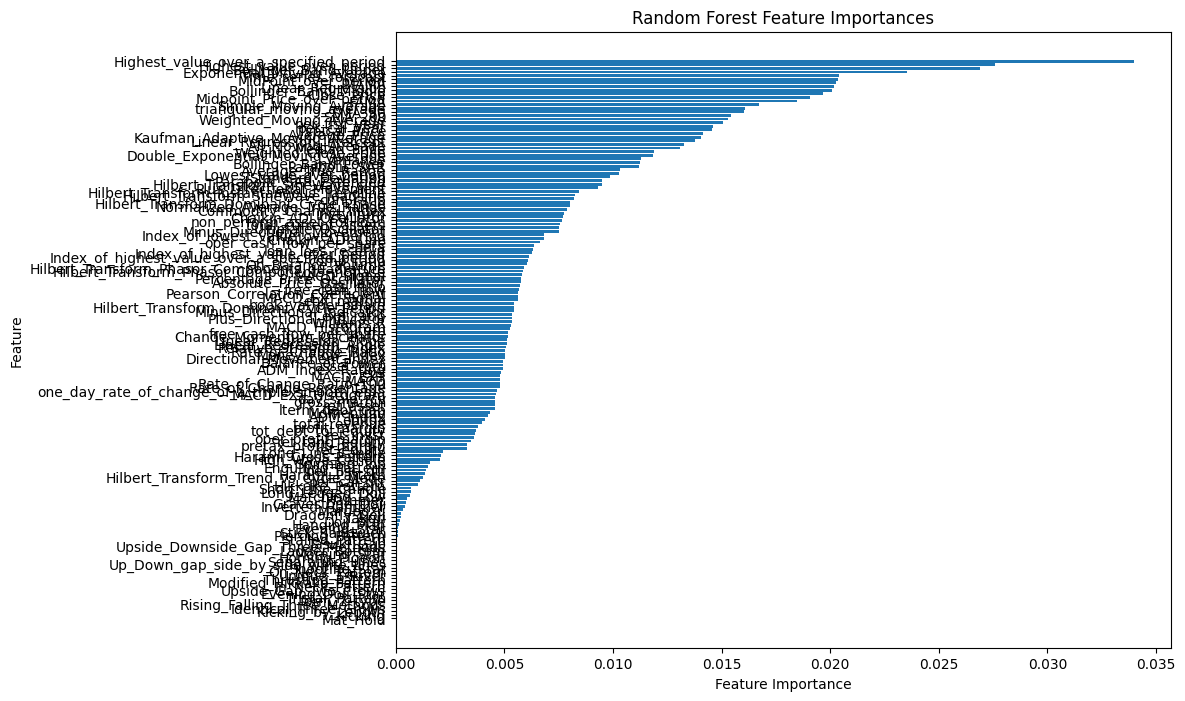

In [30]:
# Get feature importances from the model
importances = rf.feature_importances_

# Create a DataFrame for easier viewing and sorting
feature_importance_df = pd.DataFrame(
    {"Feature": x_train_numeric_scaled_df.columns, "Importance": importances}
).sort_values(by="Importance", ascending=False)

# Print the feature importances
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features on top
plt.show()

In [31]:
features = feature_importance_df[feature_importance_df["Importance"] > 0.005]
features.shape

(83, 2)

In [32]:
features.head(15)

,Feature,Importance
127,Highest_value_over_a_specified_period,0.03398782
152,Highest_value_over_period,0.02760558
43,Bollinger_Band_Upper,0.02690474
96,Exponential_Moving_Average,0.02351325
131,Time_series_forecast,0.02039988
148,MidPoint_over_period,0.02037246
125,MAMA,0.02024707
106,Linear_Regression,0.02016594
44,Bollinger_Band_Middle,0.02009639
154,Close_Price,0.01968968


In [33]:
x_train_red = x_train_numeric_scaled_df[features["Feature"]]
x_valid_red = x_valid_numeric_scaled_df[features["Feature"]]
x_test_red = x_test_numeric_scaled_df[features["Feature"]]
x_train_red.shape

(142387, 83)

In [35]:
rf = RandomForestRegressor(random_state=1, n_jobs=-1)
rf.fit(x_train_red, y_train)

# Optionally, predict and evaluate on the validation set
y_valid_pred_red = rf.predict(x_valid_red)
mse_valid_red = mean_squared_error(y_valid, y_valid_pred_red)
print("Validation MSE:", mse_valid_red)

Validation MSE: 80.81167178043538


In [36]:
# predict and then compute R2 with r2_score:
y_valid_pred_red = rf.predict(x_valid_red)
r2 = r2_score(y_valid, y_valid_pred_red)
print("R^2 score:", r2)

ss_res = np.sum((y_valid - y_valid_pred_red) ** 2)
ss_tot = np.sum((y_valid - np.mean(y_valid)) ** 2)
# r2_manual = 1 - (ss_res / ss_tot)

# print("Manual R² score:", r2_manual)
print("SS total:", ss_tot)
print("SS residual:", ss_res)

R^2 score: 0.07977087910108294
SS total: 2949242.8824932394
SS residual: 2713979.1850741417
